# Учебная задача: Анализ сайта «СберАвтоподписка»

### Задача состоит в том, чтобы по визиту предсказать, будет ли совершенно целевое действие (Оставить заявку, Заказать звонок, Открыть диалог)

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

#### Считаем датасеты

In [2]:
df_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)
df_session = pd.read_csv('data/ga_sessions.csv', low_memory=False)

#### Определим таргет

In [3]:
target = ['start_chat', 'chat requested', 'sub_callback_submit_click']

#### Получим столбец целевой переменной, есть ли в данных сессии целевое действие

In [4]:
df_session['target'] = df_session['session_id'].isin(df_hits[df_hits['event_action'].isin(target)]['session_id']).astype(int)

In [5]:
df_session

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol,0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0


#### Колонки с id сессии, id клиента не несут в себе ничего полезного. Всё, что касается времени - тоже принято решение выкинуть на данный момент

In [6]:
df_session = df_session.drop(columns=['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number'])

In [7]:
df_session.shape

(1860042, 14)

In [8]:
df_session.isna().sum() / df_session.shape[0]

utm_source                  0.000052
utm_medium                  0.000000
utm_campaign                0.118063
utm_adcontent               0.180434
utm_keyword                 0.581740
device_category             0.000000
device_os                   0.575330
device_brand                0.197403
device_model                0.991216
device_screen_resolution    0.000000
device_browser              0.000000
geo_country                 0.000000
geo_city                    0.000000
target                      0.000000
dtype: float64

#### Видим, что колонки device_model, device_os и utm_keyword имеют в себе более 50% NaN. Выкинем их

In [9]:
df_session = df_session.drop(['device_model', 'device_os', 'utm_keyword'], axis=1)

#### Затем удалим оставшиеся NaN

In [10]:
df_session = df_session.dropna().reset_index(drop=True)

In [11]:
df_session

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari,Russia,Saint Petersburg,1
4,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,tablet,Lenovo,602x1029,YaBrowser,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...
1230854,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x896,Safari,Russia,Zheleznodorozhny,0
1230855,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,ZTE,360x640,Chrome,Russia,Blagoveshchensk,0
1230856,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari,Russia,Stavropol,0
1230857,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,0


In [12]:
columns = df_session.columns[:-1]
enc = OneHotEncoder(sparse_output=False, max_categories=100)
enc.fit(df_session.drop(columns='target')[columns])
transfomed = enc.transform(df_session[columns])
df_prepared = pd.DataFrame(transfomed, columns=enc.get_feature_names_out())
df_prepared['target'] = df_session['target']

#### Датасет для обучения готов

In [15]:
df_prepared.shape

(1230859, 778)

#### Можно отметить, что у нас очень сильный перекос в 0 класс

<Axes: ylabel='Frequency'>

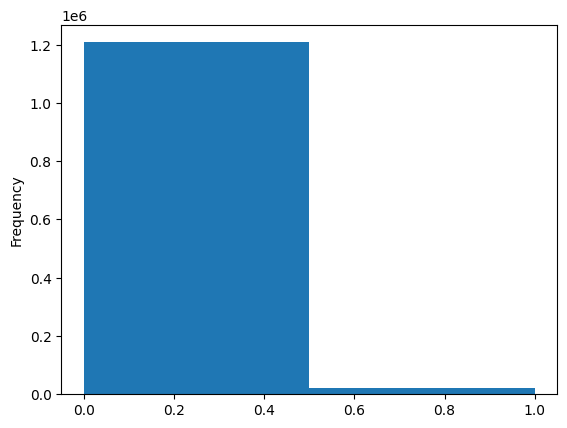

In [19]:
df_prepared['target'].plot.hist(bins=2)

In [21]:
df_prepared.to_csv('data/df_prepared.csv', index=False)